In [19]:
# 기본적인 임포트
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# 데이터 가져오기
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer( )

In [21]:
# 데이터 분할
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size=0.2, random_state=42)

In [22]:
# 검증세트 분할
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

364 91


In [23]:
# 넘파이로 표준화 구현하기
train_mean = np.mean(x_train, axis = 0)
train_std = np.std(x_train, axis = 0)
x_train_scaled = (x_train - train_mean) / train_std

In [24]:
# 올바른 전처리
x_val_scaled = (x_val - train_mean) / train_std

# 과대적합과 과소적합

과대적합이란 모델이 훈련세트에만 좋은 성능을 내고 검증세트에는 나쁜 성능을 내는 경우다.  
일반적으로, 훈련세트 정확도가 99%, 검증세트 정확도가 80%라면 과대적합을 의심할 수 있다.

</br>

과소적합은 그냥 성능자체가 구린경우다.  

</br>

즉, 우리는 성능도 우수하면서 검증세트 정확도와 훈련세트 정확도의 차이가 거의 없는  
모델을 만드는 것이 훌륭한 모델을 만드는 것이라 할 수 있다.

## 에포크 손실함수을 통한 과대적합과 과소적합 분석하기

훈련세트의 손실은 에포크가 진행될수록 감소하지만  
검증세트의 손실은 에포크의 횟수가 최적점을 지나면 오히려 상승한다.  
최적점 이후에도 훈련을 진행할 경우, 훈련세트 전용이 되어버리기 때문이다.  
  
고로 적절한 에포크 횟수를 찾는 것이 중요하다.  

## 적절한 편향-분산 트레이드오프를 선택
앞에서 과소적합된 모델은 편향되었다고 하고 과대적합된 모델은 분산이 크다고 한다.  
분산을 챙기면 편향되고 편향을 해결하면 분산이 커진다.  
때문에 이 둘 사이에서 적절한 값을 찾아내야 한다.  
</br>

지난번에 만든 클래스 코드를 변경하자

In [27]:
# SingleLayer 클래스 수정
# 지난 시간에 만든 코드
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b    # 직선 방정식을 계산
        return z

    def backprop(self, x, err):
        w_grad = x * err          # 가중치에 대한 그래디언트를 계산
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화
        self.b = 0                                 # 절편을 초기화
        self.w_history.append(self.w.copy())       # 가중치를 기록
        np.random.seed(42)                         # 랜덤 시드를 지정
        for i in range(epochs):                    # epochs만큼 반복
            loss = 0
            # 인덱스를 섞는다.
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                # 그래디언트에서 페널티 항의 미분 값을 더한다
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad         # 가중치 업데이트
                self.b -= self.lr * b_grad         # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) >= 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [28]:
# 모델 훈련
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

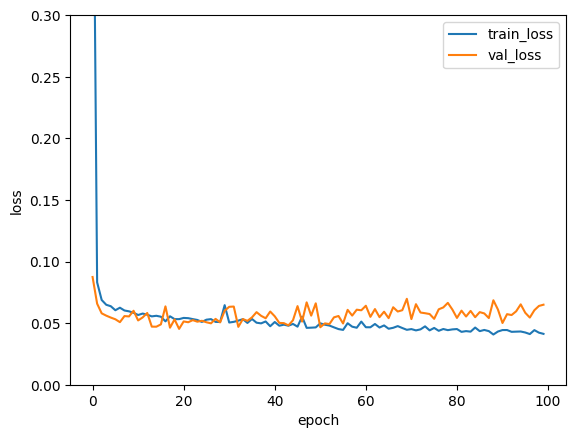

In [29]:
# 그래프 그리기
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

이 모델은 20번의 에포크 이후에는 훈련할 필요가 없을 것 같다.  
대략 50번쯤을 보면 오히려 벌어지는 것을 볼 수 있다.  

In [30]:
# 훈련 조기종료
layer4 = SingleLayer( )
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.989010989010989

성능이 조금 더 향상되었다.

---
# 규제
